In [157]:
# Import Libraries
import pandas as pd
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
import time
import matplotlib.pyplot as plt

In [158]:
np.random.seed(42)

In [159]:
# Import the Movies dataset
movies = pd.read_csv('data/movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [160]:
# Import the Rating dataset
ratings = pd.read_csv('data/rating.csv', nrows=100000)
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [161]:
# Define a custom Reader object specifying the rating scale
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise Dataset
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [162]:
def get_predictions(data, n_epochs):
    # Start time
    start_time = time.time()
    
    # Split the data into training and testing sets
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # Initialize the SVD algorithm with current number of epochs
    algo = SVD(n_epochs=n_epochs)
    
    # Train the algorithm on the training set
    algo.fit(trainset)
    
    # Make predictions on the testing set
    predictions = algo.test(testset)
    
    # End time
    end_time = time.time()
    
    # Print time consumed
    print(f"Epoch {n_epochs} done in {end_time - start_time:.2f} seconds")
    
    return predictions

In [163]:
# Lists to store epoch values and corresponding RMSE values
number_of_epochs = 30
epochs = []
rmse_values = []

# Iterate over different numbers of epochs
for n_epochs in range(1, number_of_epochs + 1):
    # Get predictions for the current number of epochs
    predictions = get_predictions(data, n_epochs)
    
    # Calculate RMSE
    rmse = accuracy.rmse(predictions, verbose=False)
    
    # Append epoch and RMSE values to lists
    epochs.append(n_epochs)
    rmse_values.append(rmse)
    print(rmse)

Epoch 1 done in 0.41 seconds
0.9701232619862418
Epoch 2 done in 0.44 seconds
0.9509118180323796
Epoch 3 done in 0.49 seconds
0.9406972467357843
Epoch 4 done in 0.55 seconds
0.9331035298928948
Epoch 5 done in 2.98 seconds
0.9300961967026651
Epoch 6 done in 0.67 seconds
0.927741932287911
Epoch 7 done in 0.74 seconds
0.9259035580928826
Epoch 8 done in 0.72 seconds
0.9247547132022351
Epoch 9 done in 0.77 seconds
0.9215668068530661
Epoch 10 done in 3.16 seconds
0.9228635378513698
Epoch 11 done in 0.88 seconds
0.9201829446351978
Epoch 12 done in 0.94 seconds
0.9196042197641586
Epoch 13 done in 0.99 seconds
0.9192618727929506
Epoch 14 done in 1.11 seconds
0.915733969390177
Epoch 15 done in 1.11 seconds
0.9179962069052987
Epoch 16 done in 3.48 seconds
0.9169319838099469
Epoch 17 done in 1.20 seconds
0.9123835799076473
Epoch 18 done in 1.26 seconds
0.9138933940630795
Epoch 19 done in 1.39 seconds
0.9135251828701675
Epoch 20 done in 1.38 seconds
0.9143153897806863
Epoch 21 done in 4.30 seconds
0

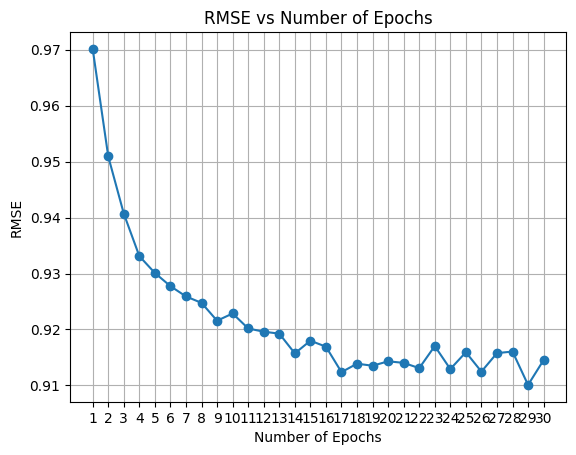

In [164]:
# Plot the graph
plt.plot(epochs, rmse_values, marker='o')
plt.title('RMSE vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.xticks(range(1, number_of_epochs + 1, 1))
plt.grid(True)
plt.show()

In [165]:
def get_svd_algorithm(data, n_epochs):
    # Start time
    start_time = time.time()
    
    # Split the data into training and testing sets
    trainset = data.build_full_trainset()
    
    # Initialize the SVD algorithm with current number of epochs
    algo = SVD(n_epochs=n_epochs, n_factors=1128)
    
    # Train the algorithm on the training set
    algo.fit(trainset)
    
    # End time
    end_time = time.time()
    
    # Print time consumed
    print(f"Epoch {n_epochs} done in {end_time - start_time:.2f} seconds")
    
    return algo

In [173]:
def get_recomendations(predicted_ratings, user_id, ratings, movies, number_of_movies):
    # Get list of all user IDs
    user_ids = ratings['userId'].unique()

    # Sort the list of user IDs
    sorted_user_ids = sorted(user_ids)

    # Find the index of the given user ID
    index_of_given_user_id = sorted_user_ids.index(user_id)

     # Find already watched movies
    watched_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()

    # Extract predicted ratings for the specified user ID
    user_predicted_ratings = predicted_ratings[index_of_given_user_id - 1]

    # Filter predicted ratings for movies not already watched
    user_predictions = [(movies.loc[movie_id]['title'], rating)
                        for movie_id, rating in enumerate(user_predicted_ratings, start=1)
                        if movie_id not in watched_movies]

    # Sort predictions by rating in descending order
    user_predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_n_recommendations = user_predictions[:number_of_movies]

    return top_n_recommendations

In [174]:
# Get top 10 recommendations for user with id 1
user_id = 1
number_of_movies = 10
algo = get_svd_algorithm(data, 20)
prediction_matrix = (algo.pu @ algo.qi.T + 1) * 2 + 1

num_users, num_movies = algo.pu.shape

print("Number of users:", num_users)
print("Number of movies:", num_movies)

num_users, num_movies = algo.qi.T.shape

print("Number of users:", num_users)
print("Number of movies:", num_movies)

top_10_user_recommendations = get_recomendations(prediction_matrix, user_id, ratings, movies, 10)
print("Top 10 recommendations for user", user_id, ":", top_10_user_recommendations)

Epoch 20 done in 8.20 seconds
Number of users: 702
Number of movies: 1128
Number of users: 1128
Number of movies: 8227
Top 10 recommendations for user 1 : [('Wings of Courage (1995)', 5.650939923389831), ('Skin Deep (1989)', 4.475939646792543), ('Three Kings (1999)', 4.436279369658498), ('Ben-Hur (1959)', 4.399178884843492), ('Full Metal Jacket (1987)', 4.299739992624891), ('Pocahontas (1995)', 4.1761127363891575), ('Junior (1994)', 4.162267053267969), ('James and the Giant Peach (1996)', 4.153909297230338), ('Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 4.098658692766535), ('Jude (1996)', 4.035148297292935)]


: 